In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
# @title Main Data
# raise Exception("Can only run one cell")
import os, requests, numpy as np

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)

main_data = np.array([])
for j in range(len(fname)):
  main_data = np.hstack((main_data,
                      np.load('steinmetz_part%d.npz'%j,
                              allow_pickle=True)['dat']))

## VISp and MOs Data

In [ ]:
all_data = main_data[25]

VISp_spikes = all_data['spks'][all_data['brain_area'] == 'VISp']
MOs_spikes = all_data['spks'][all_data['brain_area'] == 'MOs']


In [ ]:
VISp_spikes = all_data['spks'][all_data['brain_area'] == 'VISp'] #neurons by trials by time bins
MOs_spikes = all_data['spks'][all_data['brain_area'] == 'MOs'] #neurons by trials by time bins
print(VISp_spikes.shape)
print(MOs_spikes.shape)

(162, 178, 250)
(166, 178, 250)


 ## First, analyze the correlations between the neurons considering all trials together.

In [ ]:
# Reshape the spike data
VISp_spikes_reshaped = VISp_spikes.reshape(VISp_spikes.shape[0], -1)
MOs_spikes_reshaped = MOs_spikes.reshape(MOs_spikes.shape[0], -1)

print(VISp_spikes_reshaped.shape)
print(MOs_spikes_reshaped.shape)

# Compute the correlation matrix
VISp_corr_matrix = np.corrcoef(VISp_spikes_reshaped)
MOs_corr_matrix = np.corrcoef(MOs_spikes_reshaped)

(162, 44500)
(166, 44500)


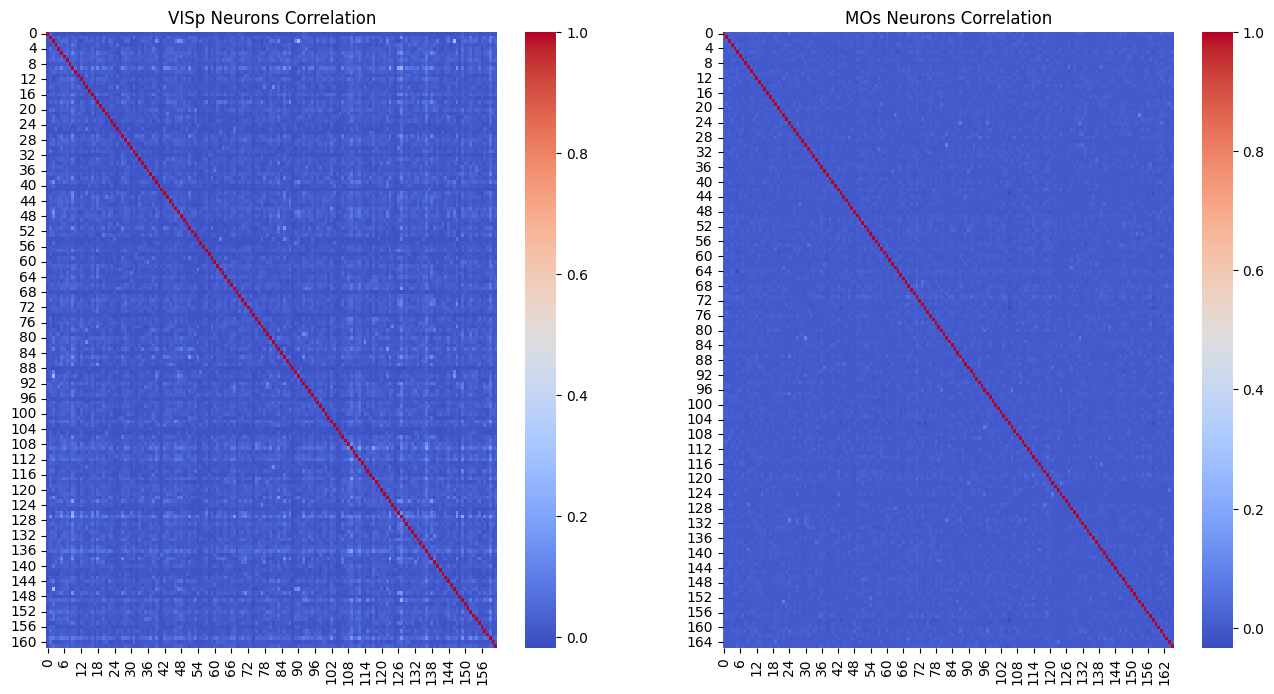

In [ ]:
# Plot the heatmap for each brain region
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

sns.heatmap(VISp_corr_matrix, ax=axs[0], cmap='coolwarm')
axs[0].set_title('VISp Neurons Correlation')

sns.heatmap(MOs_corr_matrix, ax=axs[1], cmap='coolwarm')
axs[1].set_title('MOs Neurons Correlation')

plt.show()




Extract the correlation values that do not provide additional information

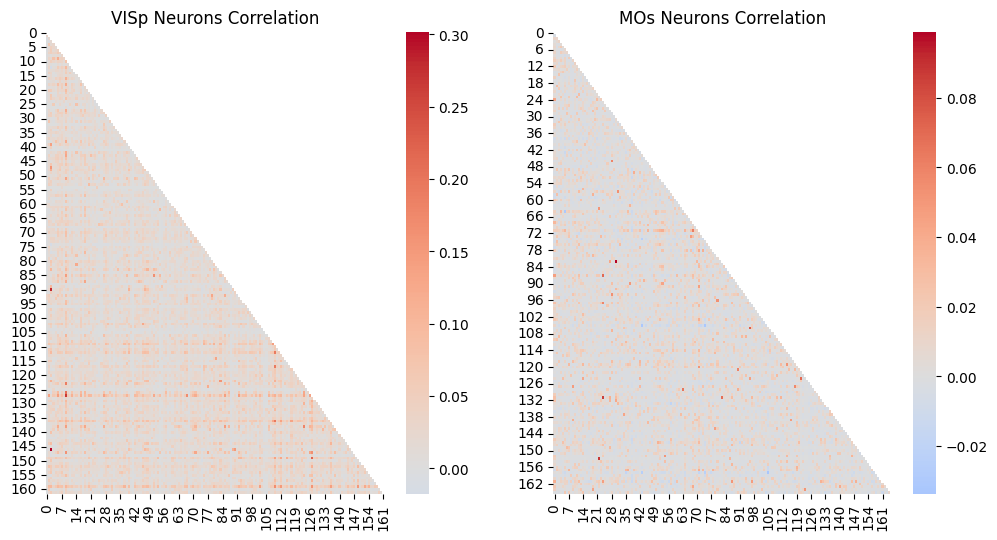

In [ ]:
# Mask for the upper triangle and diagonal
VISp_mask = np.triu(np.ones_like(VISp_corr_matrix, dtype=bool))
MOs_mask = np.triu(np.ones_like(MOs_corr_matrix, dtype=bool))

# Get the maximum and minimum correlation values for the color scale
VISp_max_corr = np.max(VISp_corr_matrix[np.tril_indices_from(VISp_corr_matrix, k=-1)])
VISp_min_corr = np.min(VISp_corr_matrix[np.tril_indices_from(VISp_corr_matrix, k=-1)])
MOs_max_corr = np.max(MOs_corr_matrix[np.tril_indices_from(MOs_corr_matrix, k=-1)])
MOs_min_corr = np.min(MOs_corr_matrix[np.tril_indices_from(MOs_corr_matrix, k=-1)])

# Plot the heatmap
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot for VISp
sns.heatmap(VISp_corr_matrix, ax=axs[0], mask=VISp_mask, cmap='coolwarm', center=0, vmin=VISp_min_corr, vmax=VISp_max_corr, annot=False)
axs[0].set_title('VISp Neurons Correlation')

# Plot for MOs
sns.heatmap(MOs_corr_matrix, ax=axs[1], mask=MOs_mask, cmap='coolwarm', center=0, vmin=MOs_min_corr, vmax=MOs_max_corr, annot=False)
axs[1].set_title('MOs Neurons Correlation')

plt.show()



Now we can analyze the correlation between neurons in both regions (the first 162 neurons are VISp)

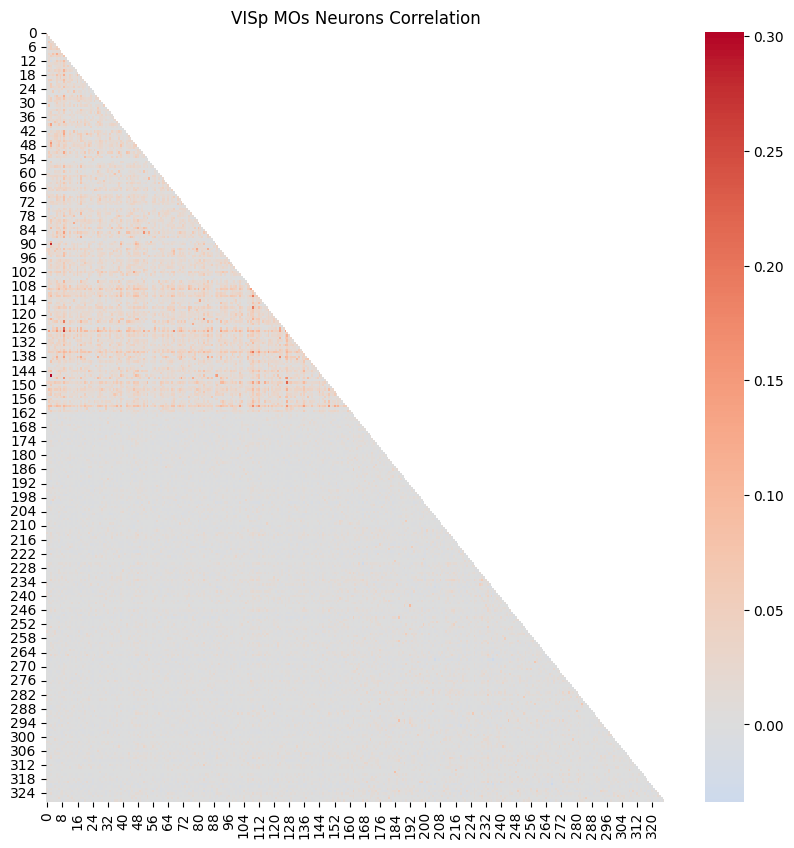

In [ ]:
# Combine the reshaped spike data
combined_spikes_reshaped = np.concatenate((VISp_spikes_reshaped, MOs_spikes_reshaped), axis=0)

# Compute the correlation matrix for the combined data
combined_corr_matrix = np.corrcoef(combined_spikes_reshaped)

# Mask the upper triangle and the diagonal
mask = np.triu(np.ones_like(combined_corr_matrix, dtype=bool))

# Get the maximum and minimum correlation values for the color scale
max_corr = np.max(combined_corr_matrix[np.tril_indices_from(combined_corr_matrix, k=-1)])
min_corr = np.min(combined_corr_matrix[np.tril_indices_from(combined_corr_matrix, k=-1)])

# Plot the heatmap with the lower triangle only
plt.figure(figsize=(10, 10))
sns.heatmap(combined_corr_matrix, mask=mask, cmap='coolwarm', center=0, vmin=min_corr, vmax=max_corr, annot=False)
plt.title('VISp MOs Neurons Correlation')
plt.show()



## We observe very low correlation values, so we can investigate what happens with data from just one trial (the first one)

In [ ]:
# Function to compute correlation matrix and handle zero variance columns
def compute_corr_matrix(spikes):
    # Add a small constant to the standard deviation to avoid division by zero
    stddev = np.std(spikes, axis=1, keepdims=True)
    stddev[stddev == 0] = 1e-10

    # Normalize the data
    spikes = (spikes - np.mean(spikes, axis=1, keepdims=True)) / stddev

    # Compute the correlation matrix
    corr_matrix = np.corrcoef(spikes)

    # Replace NaN with zero
    corr_matrix = np.nan_to_num(corr_matrix)

    return corr_matrix

(162, 250)
(166, 250)


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


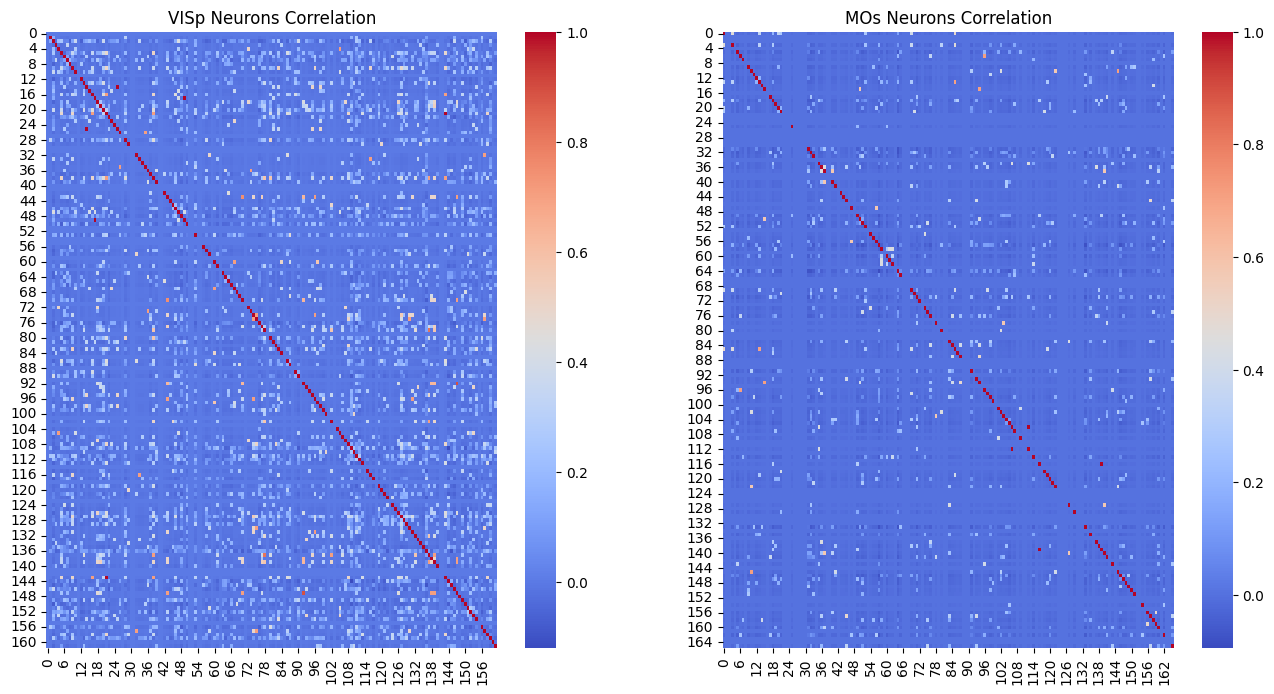

In [ ]:
# Reshape the spike data

VISp_spikes_reshaped_ = VISp_spikes[:, 0, :]
MOs_spikes_reshaped_ = MOs_spikes[:, 0, :]

print(VISp_spikes_reshaped_.shape)
print(MOs_spikes_reshaped_.shape)

# Compute the correlation matrices
VISp_corr_matrix = compute_corr_matrix(VISp_spikes_reshaped_)
MOs_corr_matrix = compute_corr_matrix(MOs_spikes_reshaped_)

# Plot the heatmap
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

sns.heatmap(VISp_corr_matrix, ax=axs[0], cmap='coolwarm')
axs[0].set_title('VISp Neurons Correlation')

sns.heatmap(MOs_corr_matrix, ax=axs[1], cmap='coolwarm')
axs[1].set_title('MOs Neurons Correlation')

plt.show()




VISp shape (162, 162)
MOs shape (166, 166)


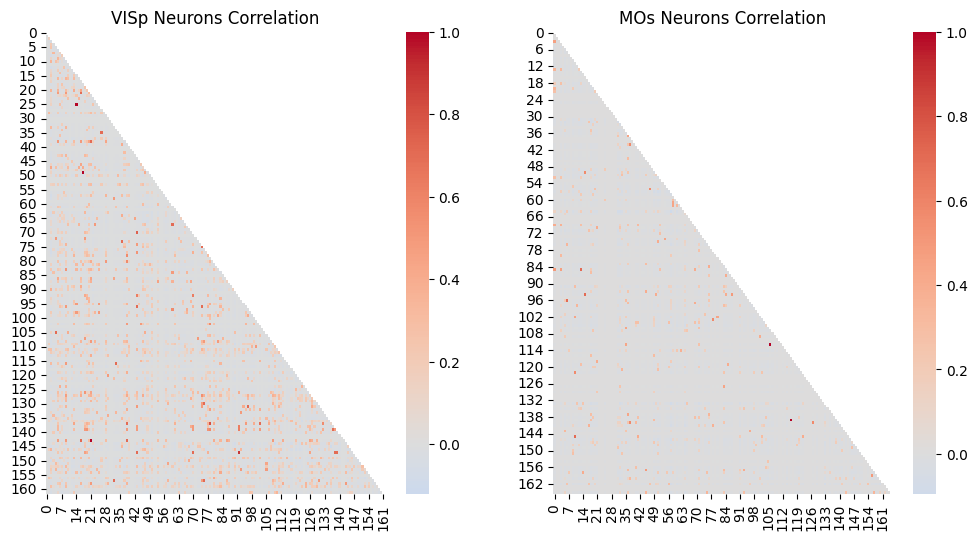

In [ ]:
# Mask for the upper triangle and diagonal
VISp_mask = np.triu(np.ones_like(VISp_corr_matrix, dtype=bool))
MOs_mask = np.triu(np.ones_like(MOs_corr_matrix, dtype=bool))
print('VISp shape', VISp_mask.shape)
print('MOs shape',MOs_mask.shape)

# Get the maximum and minimum correlation values for the color scale
VISp_max_corr = np.max(VISp_corr_matrix[np.tril_indices_from(VISp_corr_matrix, k=-1)])
VISp_min_corr = np.min(VISp_corr_matrix[np.tril_indices_from(VISp_corr_matrix, k=-1)])
MOs_max_corr = np.max(MOs_corr_matrix[np.tril_indices_from(MOs_corr_matrix, k=-1)])
MOs_min_corr = np.min(MOs_corr_matrix[np.tril_indices_from(MOs_corr_matrix, k=-1)])

# Plot the heatmap
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot for VISp
sns.heatmap(VISp_corr_matrix, ax=axs[0], mask=VISp_mask, cmap='coolwarm', center=0, vmin=VISp_min_corr, vmax=VISp_max_corr, annot=False)
axs[0].set_title('VISp Neurons Correlation')

# Plot for MOs
sns.heatmap(MOs_corr_matrix, ax=axs[1], mask=MOs_mask, cmap='coolwarm', center=0, vmin=MOs_min_corr, vmax=MOs_max_corr, annot=False)
axs[1].set_title('MOs Neurons Correlation')

plt.show()

(162, 250)
(166, 250)
(328, 328)


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


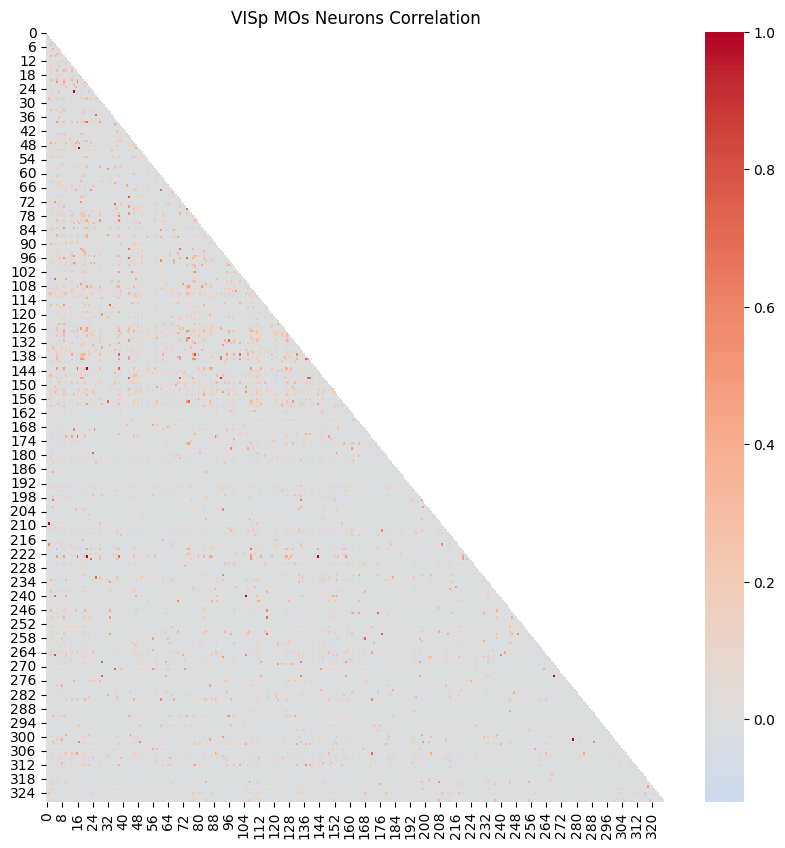

In [ ]:
# Combine the reshaped spike data
print(VISp_spikes_reshaped_.shape)
print(MOs_spikes_reshaped_.shape)

num_VISp_neurons = VISp_spikes_reshaped_.shape[0]
num_MOs_neurons = MOs_spikes_reshaped_.shape[0]

combined_spikes_reshaped = np.concatenate((VISp_spikes_reshaped_, MOs_spikes_reshaped_), axis=0)

# Compute the correlation matrix for the combined data
combined_corr_matrix = compute_corr_matrix(combined_spikes_reshaped)
print(combined_corr_matrix.shape)
# Mask the upper triangle and the diagonal
mask = np.triu(np.ones_like(combined_corr_matrix, dtype=bool))

# Get the maximum and minimum correlation values for the color scale
max_corr = np.max(combined_corr_matrix[np.tril_indices_from(combined_corr_matrix, k=-1)])
min_corr = np.min(combined_corr_matrix[np.tril_indices_from(combined_corr_matrix, k=-1)])

# Plot the heatmap with the lower triangle only
plt.figure(figsize=(10, 10))
sns.heatmap(combined_corr_matrix, mask=mask, cmap='coolwarm', center=0, vmin=min_corr, vmax=max_corr, annot=False)
plt.title('VISp MOs Neurons Correlation')
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 1000x1000 with 0 Axes>

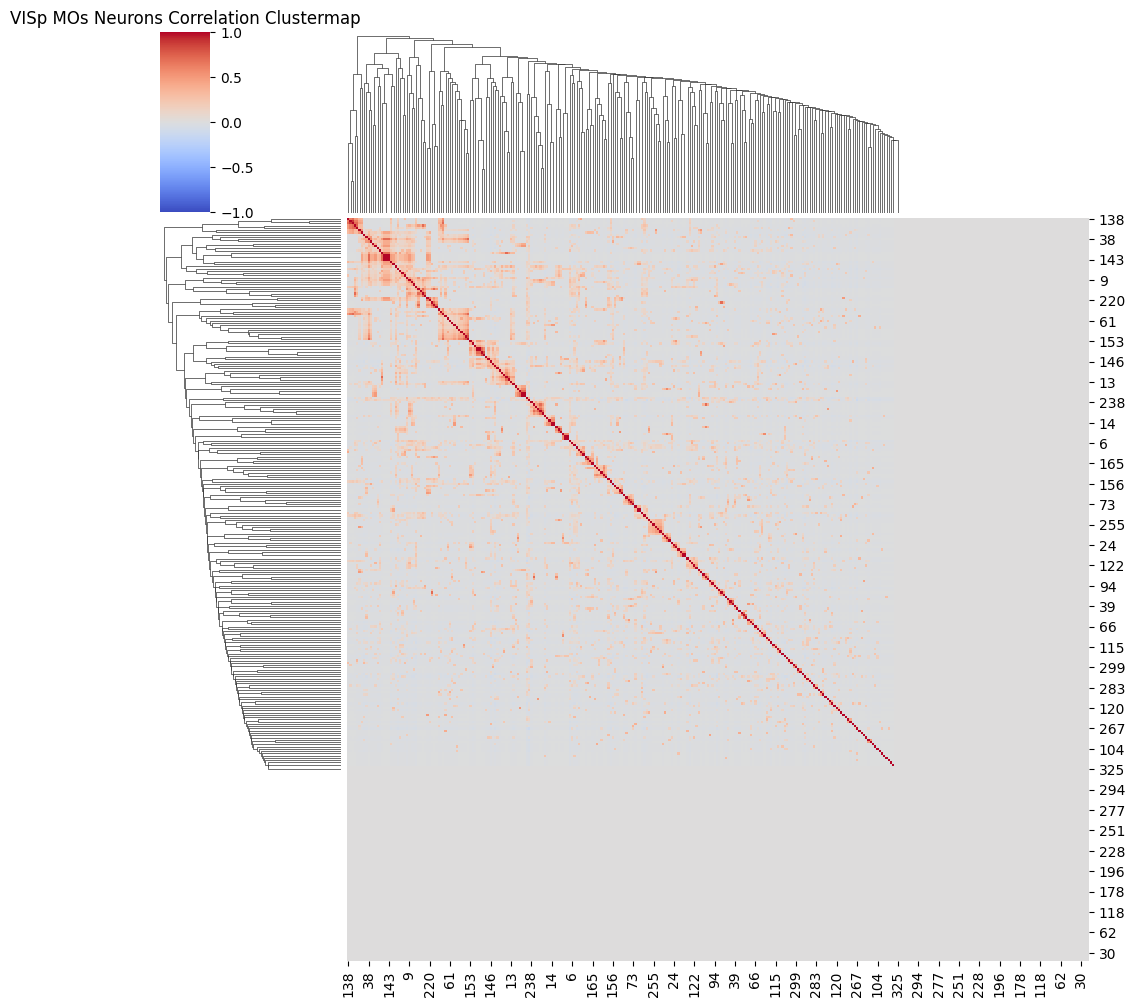

In [ ]:
# Plot the clustermap
plt.figure(figsize=(10, 10))
sns.clustermap(combined_corr_matrix, cmap='coolwarm', center=0, vmin=-1, vmax=1)
plt.title('VISp MOs Neurons Correlation Clustermap')
plt.show()


In [ ]:
visual_spks = all_data['spks'][all_data['brain_area']=='VISp']
visual_spks_peri_stim = visual_spks[:,:,50:80]
visual_spks_mean = visual_spks_peri_stim.mean(axis=2)
visual_spks_mean.shape # n_neurons, n_trials


motor_spks = all_data['spks'][all_data['brain_area']=='MOs']
motor_spks_peri_stim = motor_spks[:,:,50:100]
motor_spks_mean = motor_spks_peri_stim.mean(axis=2)
motor_spks_mean.shape # n_neurons, n_trials

print(visual_spks_mean.shape)
print(motor_spks_mean.shape)

(162, 178)
(166, 178)


In [ ]:
# Compute the correlation matrix
VISp_corr_matrix = np.corrcoef(visual_spks_mean )

MOs_corr_matrix = np.corrcoef(motor_spks_mean)

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


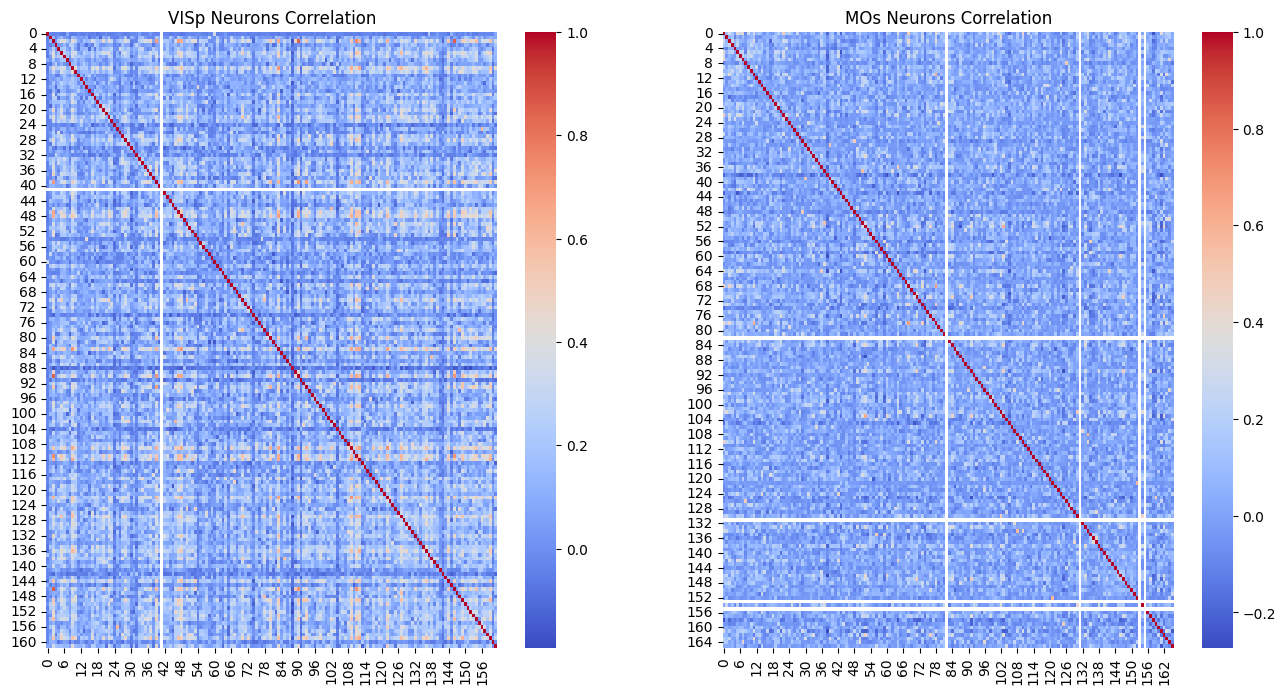

In [ ]:
# Plot the heatmap
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

sns.heatmap(VISp_corr_matrix, ax = axs[0], cmap='coolwarm')
axs[0].set_title('VISp Neurons Correlation')

sns.heatmap(MOs_corr_matrix, ax= axs[1], cmap='coolwarm')
axs[1].set_title('MOs Neurons Correlation')

plt.show()

(162, 250)
(166, 250)
(328, 328)


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


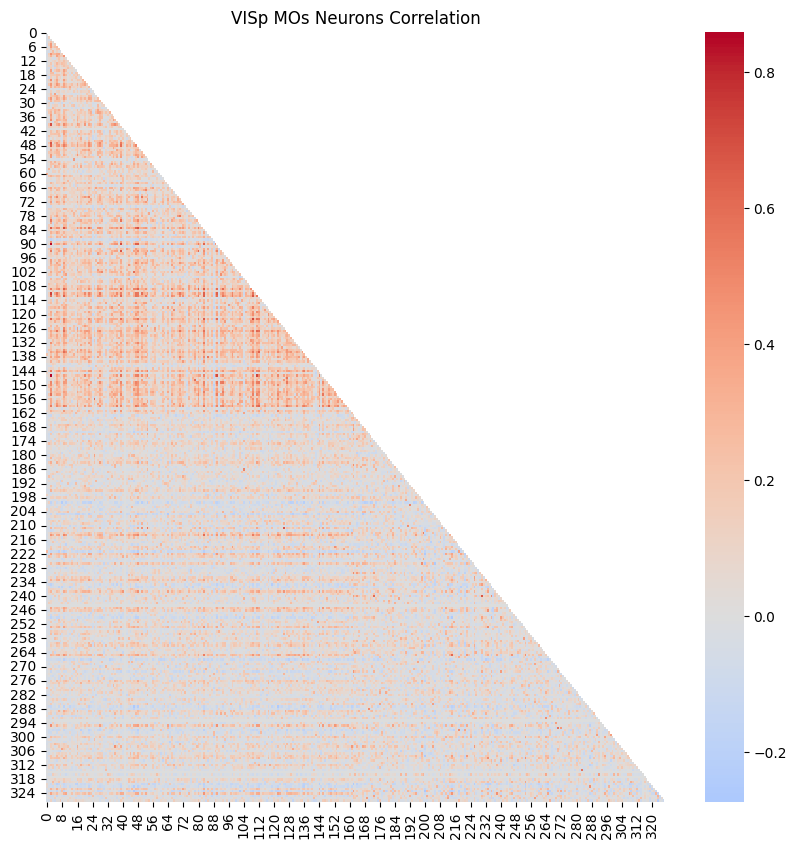

In [ ]:
# Combine the reshaped spike data
print(VISp_spikes_reshaped_.shape)
print(MOs_spikes_reshaped_.shape)

num_VISp_neurons = VISp_spikes_reshaped_.shape[0]
num_MOs_neurons = MOs_spikes_reshaped_.shape[0]

combined_spikes_reshaped = np.concatenate((visual_spks_mean, motor_spks_mean), axis=0)

# Compute the correlation matrix for the combined data
combined_corr_matrix = compute_corr_matrix(combined_spikes_reshaped)
print(combined_corr_matrix.shape)
# Mask the upper triangle and the diagonal
mask = np.triu(np.ones_like(combined_corr_matrix, dtype=bool))

# Get the maximum and minimum correlation values for the color scale
max_corr = np.max(combined_corr_matrix[np.tril_indices_from(combined_corr_matrix, k=-1)])
min_corr = np.min(combined_corr_matrix[np.tril_indices_from(combined_corr_matrix, k=-1)])

# Plot the heatmap with the lower triangle only
plt.figure(figsize=(10, 10))
sns.heatmap(combined_corr_matrix, mask=mask, cmap='coolwarm', center=0, vmin=min_corr, vmax=max_corr, annot=False)
plt.title('VISp MOs Neurons Correlation')
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 1000x1000 with 0 Axes>

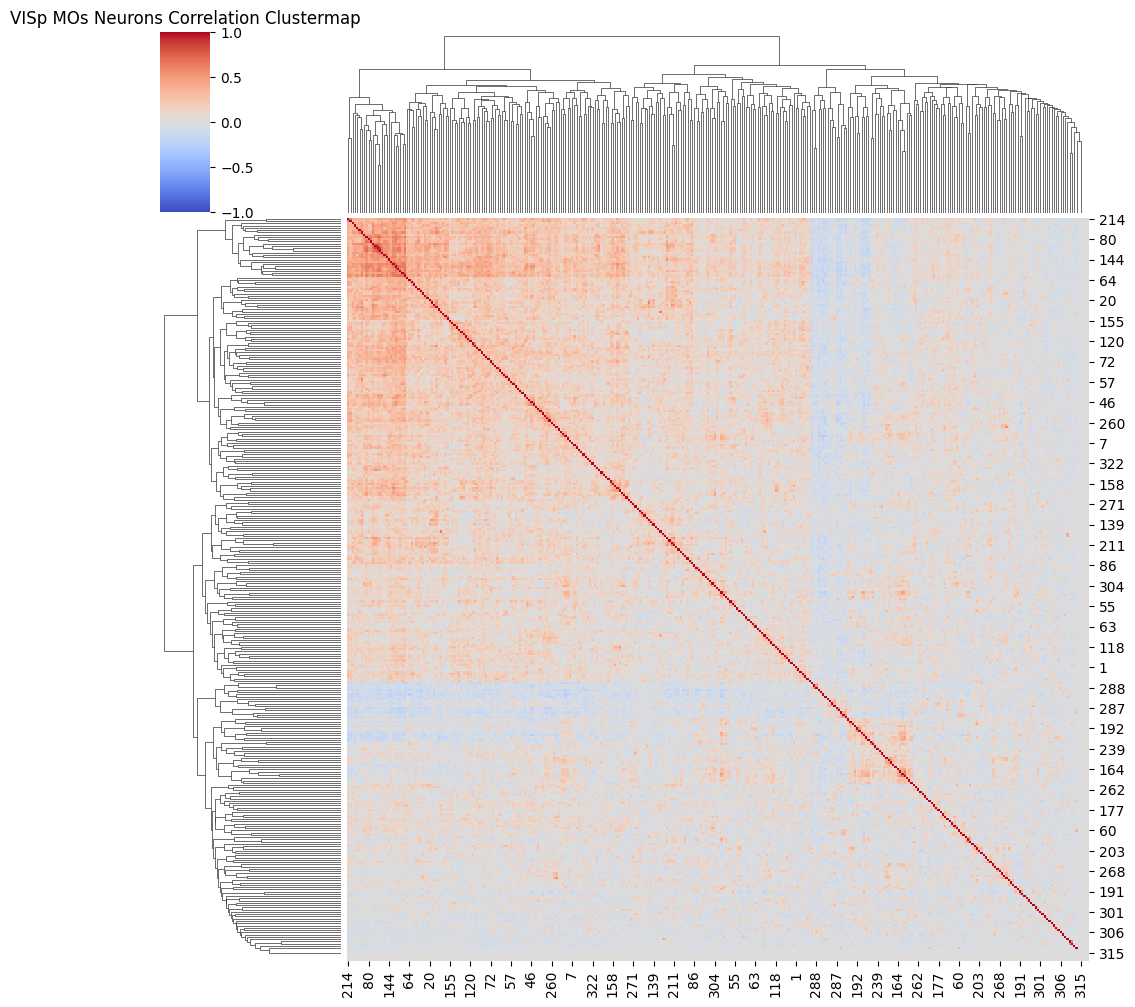

In [ ]:
plt.figure(figsize=(10, 10))
sns.clustermap(combined_corr_matrix, cmap='coolwarm', center=0, vmin=-1, vmax=1)
plt.title('VISp MOs Neurons Correlation Clustermap')
plt.show()

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Correlación media entre neuronas VISp: 0.1287614310425895
Correlación media entre neuronas MOs: 0.026952517823504555
Correlación media cruzada entre neuronas VISp y MOs: 0.035304706006121865


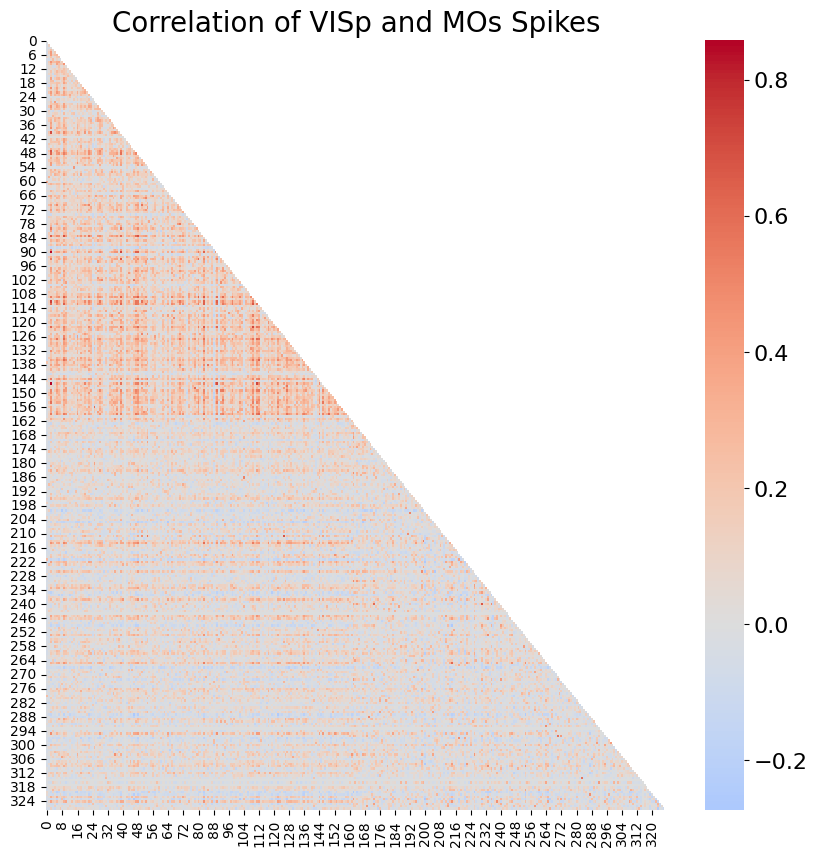

In [ ]:


# Calcular las matrices de correlación
visp_corr_matrix = compute_corr_matrix(visual_spks_mean)
mos_corr_matrix = compute_corr_matrix(motor_spks_mean)

# Combinar los datos para la matriz de correlación cruzada
combined_spikes_reshaped = np.concatenate((visual_spks_mean, motor_spks_mean), axis=0)
combined_corr_matrix = compute_corr_matrix(combined_spikes_reshaped)

# Máscara para la correlación cruzada (sin contar la diagonal ni las submatrices)
num_VISp_neurons = VISp_spikes_reshaped_.shape[0]
num_MOs_neurons = MOs_spikes_reshaped_.shape[0]

# Máscara para obtener solo las correlaciones cruzadas
cross_corr_mask = np.ones_like(combined_corr_matrix, dtype=bool)
cross_corr_mask[:num_VISp_neurons, :num_VISp_neurons] = False  # Excluir submatriz VISp
cross_corr_mask[num_VISp_neurons:, num_VISp_neurons:] = False  # Excluir submatriz MOs
np.fill_diagonal(cross_corr_mask, False)

# Extraer las correlaciones relevantes
visp_correlations = visp_corr_matrix[np.triu_indices(num_VISp_neurons, k=1)]
mos_correlations = mos_corr_matrix[np.triu_indices(num_MOs_neurons, k=1)]
cross_correlations = combined_corr_matrix[cross_corr_mask]

# Calcular las medias
mean_visp_correlation = np.mean(visp_correlations)
mean_mos_correlation = np.mean(mos_correlations)
mean_cross_correlation = np.mean(cross_correlations)

print(f'Correlación media entre neuronas VISp: {mean_visp_correlation}')
print(f'Correlación media entre neuronas MOs: {mean_mos_correlation}')
print(f'Correlación media cruzada entre neuronas VISp y MOs: {mean_cross_correlation}')

# Visualizar la matriz de correlación combinada
mask = np.triu(np.ones_like(combined_corr_matrix, dtype=bool))
max_corr = np.max(combined_corr_matrix[np.tril_indices_from(combined_corr_matrix, k=-1)])
min_corr = np.min(combined_corr_matrix[np.tril_indices_from(combined_corr_matrix, k=-1)])

plt.figure(figsize=(10, 10))
# Crear el heatmap
ax = sns.heatmap(combined_corr_matrix, mask=mask, cmap='coolwarm', center=0, vmin=min_corr, vmax=max_corr, annot=False)

# Obtener la barra de color
colorbar = ax.collections[0].colorbar

# Ajustar el tamaño de la fuente de las etiquetas de la barra de color
colorbar.ax.tick_params(labelsize=16)
plt.title('Correlation of VISp and MOs Spikes', fontsize=20)

plt.savefig('correlation_matrix.png')
plt.show()

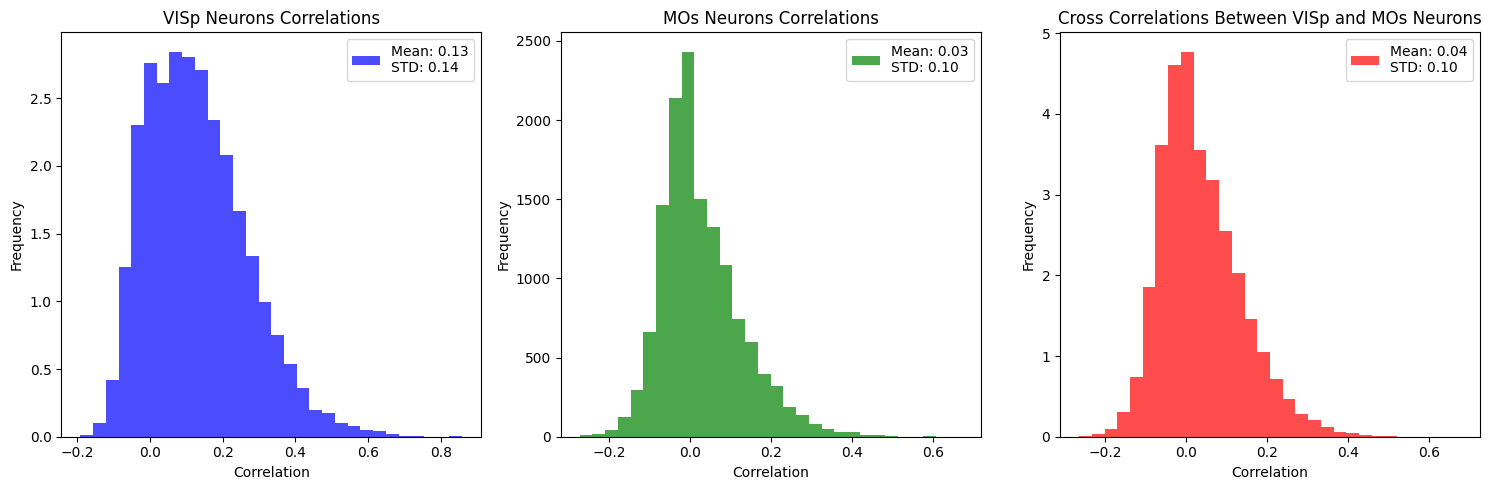

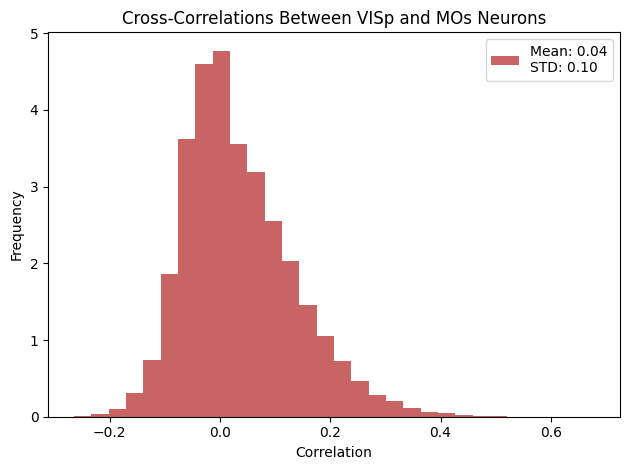

In [46]:

# Máscara para obtener solo las correlaciones cruzadas
cross_corr_mask = np.ones_like(combined_corr_matrix, dtype=bool)
cross_corr_mask[:num_VISp_neurons, :num_VISp_neurons] = False  # Excluir submatriz VISp
cross_corr_mask[num_VISp_neurons:, num_VISp_neurons:] = False  # Excluir submatriz MOs
np.fill_diagonal(cross_corr_mask, False)

# Extraer las correlaciones relevantes
visp_correlations = visp_corr_matrix[np.triu_indices(num_VISp_neurons, k=1)]
mos_correlations = mos_corr_matrix[np.triu_indices(num_MOs_neurons, k=1)]
cross_correlations = combined_corr_matrix[cross_corr_mask]

# Calculate means and standard deviations
mean_visp_corr = np.mean(visp_correlations)
std_visp_corr = np.std(visp_correlations)
mean_mos_corr = np.mean(mos_correlations)
std_mos_corr = np.std(mos_correlations)
mean_cross_corr = np.mean(cross_correlations)
std_cross_corr = np.std(cross_correlations)

# Create histograms of the correlations
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(visp_correlations, bins=30, color='b', alpha=0.7, density = True)
plt.title('VISp Neurons Correlations')
plt.xlabel('Correlation')
plt.ylabel('Frequency')
plt.legend([f'Mean: {mean_visp_corr:.2f}\nSTD: {std_visp_corr:.2f}'])

plt.subplot(1, 3, 2)
plt.hist(mos_correlations, bins=30, color='g', alpha=0.7)
plt.title('MOs Neurons Correlations')
plt.xlabel('Correlation')
plt.ylabel('Frequency')
plt.legend([f'Mean: {mean_mos_corr:.2f}\nSTD: {std_mos_corr:.2f}'])

plt.subplot(1, 3, 3)
plt.hist(cross_correlations, bins=30, color='r', alpha=0.7, density = True)
plt.title('Cross Correlations Between VISp and MOs Neurons')
plt.xlabel('Correlation')
plt.ylabel('Frequency')
plt.legend([f'Mean: {mean_cross_corr:.2f}\nSTD: {std_cross_corr:.2f}'])

plt.tight_layout()
plt.show()

plt.hist(cross_correlations, bins=30, color='firebrick', alpha=0.7, density = True)
plt.title('Cross-Correlations Between VISp and MOs Neurons')
plt.xlabel('Correlation')
plt.ylabel('Frequency')
plt.legend([f'Mean: {mean_cross_corr:.2f}\nSTD: {std_cross_corr:.2f}'])

plt.tight_layout()
plt.savefig('cross_correlation_histogram.png')
plt.show()

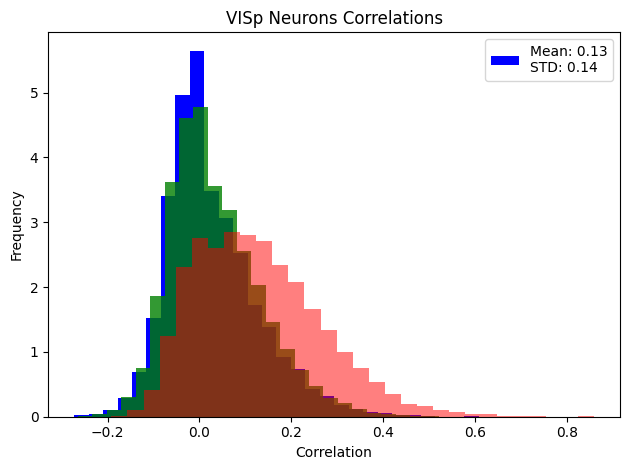

In [47]:
cross_corr_mask = np.ones_like(combined_corr_matrix, dtype=bool)
cross_corr_mask[:num_VISp_neurons, :num_VISp_neurons] = False  # Excluir submatriz VISp
cross_corr_mask[num_VISp_neurons:, num_VISp_neurons:] = False  # Excluir submatriz MOs
np.fill_diagonal(cross_corr_mask, False)

# Extraer las correlaciones relevantes
visp_correlations = visp_corr_matrix[np.triu_indices(num_VISp_neurons, k=1)]
mos_correlations = mos_corr_matrix[np.triu_indices(num_MOs_neurons, k=1)]
cross_correlations = combined_corr_matrix[cross_corr_mask]

# Calculate means and standard deviations
mean_visp_corr = np.mean(visp_correlations)
std_visp_corr = np.std(visp_correlations)
mean_mos_corr = np.mean(mos_correlations)
std_mos_corr = np.std(mos_correlations)
mean_cross_corr = np.mean(cross_correlations)
std_cross_corr = np.std(cross_correlations)

# Create histograms of the correlations

plt.hist(mos_correlations, bins=30, color='b', density = True)
plt.title('MOs Neurons Correlations')
plt.xlabel('Correlation')
plt.ylabel('Frequency')
plt.legend([f'Mean: {mean_mos_corr:.2f}\nSTD: {std_mos_corr:.2f}'])

plt.hist(cross_correlations, bins=30, color='g', alpha=0.8, density = True)
plt.title('Cross Correlations Between VISp and MOs Neurons')
plt.xlabel('Correlation')
plt.ylabel('Frequency')
plt.legend([f'Mean: {mean_cross_corr:.2f}\nSTD: {std_cross_corr:.2f}'])

plt.hist(visp_correlations, bins=30, color='r', alpha=0.5, density = True)
plt.title('VISp Neurons Correlations')
plt.xlabel('Correlation')
plt.ylabel('Frequency')
plt.legend([f'Mean: {mean_visp_corr:.2f}\nSTD: {std_visp_corr:.2f}'])

plt.tight_layout()
plt.show()

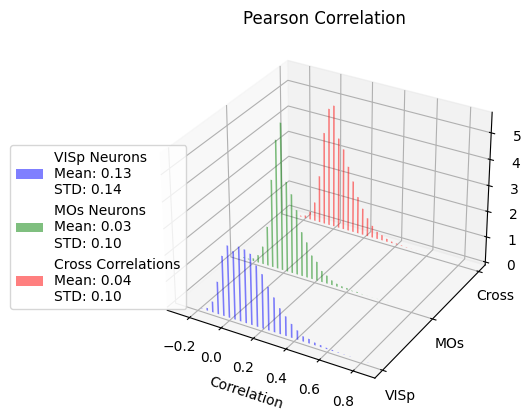

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Estilo de la gráfica
plt.style.use('default')

# Datos y máscaras
cross_corr_mask = np.ones_like(combined_corr_matrix, dtype=bool)
cross_corr_mask[:num_VISp_neurons, :num_VISp_neurons] = False  # Excluir submatriz VISp
cross_corr_mask[num_VISp_neurons:, num_VISp_neurons:] = False  # Excluir submatriz MOs
np.fill_diagonal(cross_corr_mask, False)

visp_correlations = visp_corr_matrix[np.triu_indices(num_VISp_neurons, k=1)]
mos_correlations = mos_corr_matrix[np.triu_indices(num_MOs_neurons, k=1)]
cross_correlations = combined_corr_matrix[cross_corr_mask]

# Calcular medias y desviaciones estándar
mean_visp_corr = np.mean(visp_correlations)
std_visp_corr = np.std(visp_correlations)
mean_mos_corr = np.mean(mos_correlations)
std_mos_corr = np.std(mos_correlations)
mean_cross_corr = np.mean(cross_correlations)
std_cross_corr = np.std(cross_correlations)

# Crear histogramas en 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Histogramas
bins = 30

hist_visp, bins_visp = np.histogram(visp_correlations, bins=bins, density=True)
hist_mos, bins_mos = np.histogram(mos_correlations, bins=bins, density=True)
hist_cross, bins_cross = np.histogram(cross_correlations, bins=bins, density=True)

# Coordenadas para los histogramas
x_visp = (bins_visp[:-1] + bins_visp[1:]) / 2
y_visp = np.zeros_like(x_visp)
z_visp = hist_visp

x_mos = (bins_mos[:-1] + bins_mos[1:]) / 2
y_mos = np.ones_like(x_mos) * 2
z_mos = hist_mos

x_cross = (bins_cross[:-1] + bins_cross[1:]) / 2
y_cross = np.ones_like(x_cross) * 4
z_cross = hist_cross

# Plotear los histogramas
ax.bar(x_visp, z_visp, zs=y_visp, zdir='y', color='b', alpha=0.5, width=0.01, label=f'VISp Neurons\nMean: {mean_visp_corr:.2f}\nSTD: {std_visp_corr:.2f}')
ax.bar(x_mos, z_mos, zs=y_mos, zdir='y', color='g', alpha=0.5, width=0.01, label=f'MOs Neurons\nMean: {mean_mos_corr:.2f}\nSTD: {std_mos_corr:.2f}')
ax.bar(x_cross, z_cross, zs=y_cross, zdir='y', color='r', alpha=0.5, width=0.01, label=f'Cross Correlations\nMean: {mean_cross_corr:.2f}\nSTD: {std_cross_corr:.2f}')

# Configuración del gráfico
ax.set_xlabel('Correlation')

ax.set_zlabel('Frequency')
ax.set_yticks([0, 2, 4])
ax.set_yticklabels(['VISp', 'MOs', 'Cross'])

plt.legend(loc = (-0.35,0.25))
plt.title('Pearson Correlation')
plt.savefig('correlations_histogram_3.png')
plt.show()
